In [1]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset



In [2]:
# For Local
TrainSource = "./GeneratedData/TrainData.pickle"
TestSource = "./GeneratedData/TestData.pickle"

FileSource = "./GeneratedData/allData.pickle"
ScalerPath = "./GeneratedData/Scaler.pickle"
ModelPath = "./GeneratedData/Model.pickle"

In [3]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

HeaderWithoutAccel = ["ApproachRateOther", 
                      "Rel_Pos_Magnitude", 
                      "SteerB", 
                      "A_Head_Center_Distance", "B_Head_Center_Distance", 
                      "Filtered_B_Head_Velocity_Total",
                      "A_Turn",
                      "B_Indicator",
                      "Centerline_Offset_B",
                      "RelativeRotation"] # Signaling ()

# outputHeader = ["Centerline_Offset_A"]
outputHeader = ["AccelA"]
                
input_size = len(HeaderWithoutAccel)
hidden_size = 6
# TargetTimeLength = 0.75 ## in seconds
output_size = len(outputHeader)

In [3]:
FileSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/allData.pickle"
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)



HeaderWithoutAccel = ["ApproachRate", "Rel_Pos_Magnitude", "ScenarioTime", "SteerB", "A_Head_Center_Distance", "B_Head_Center_Distance", "Filtered_A_Head_Velocity_Total", "Filtered_B_Head_Velocity_Total","RelativeRotation","SteerA"]
outputHeader = ["AccelA"]
input_size = len(HeaderWithoutAccel)
hidden_size = 6
output_size = len(outputHeader)

In [4]:

scaler = StandardScaler()
for file_path in FileList:
    # Load data (this assumes each file fits into memory)
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    features = data[HeaderWithoutAccel]
    scaler.partial_fit(features)

In [5]:

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)   # First layer
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))  # Activation function for hidden layer
        x = self.output(x)
        return x



# Create an instance of the network
net = SimpleNN(len(HeaderWithoutAccel), hidden_size, output_size)

criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001


In [6]:
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)


In [7]:
def get_dataloader(file_paths, scaler, batch_size=128):
    all_features = []
    all_targets = []
    for file_path in file_paths:
        data = pd.read_feather(file_path)
        features = data[HeaderWithoutAccel]  # assuming the last column is the target
        targets = data[outputHeader]   # assuming the last column is the target

        # Scale the features using the scaler
        scaled_features = scaler.transform(features)

        # Append the features and targets to the respective lists
        all_features.append(scaled_features)
        all_targets.append(targets.values)

    # Concatenate all the data
    all_features = np.vstack(all_features)
    all_targets = np.concatenate(all_targets)

    # Convert to PyTorch tensors
    tensor_x = torch.Tensor(all_features)
    tensor_y = torch.Tensor(all_targets)

    # Create a dataset and dataloader
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader

In [8]:
# Prepare the DataLoaders
train_loader = get_dataloader(train_files, scaler)
test_loader = get_dataloader(test_files, scaler)

In [10]:
num_epochs = 100
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    net.train()
    for inputs, targets in train_loader:
      optimizer.zero_grad()

      outputs = net(inputs)
     # print(outputs.shape,targets.shape)
      loss = criterion(outputs, targets)  # Make sure targets are the correct shape
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    net.eval()
    with torch.no_grad():
      test_loss = 0
      for inputs, targets in test_loader:
        outputs = net(inputs)
        batch_loss = criterion(outputs, targets).item()
        test_loss += batch_loss # Sum up batch loss
        test_losses.append(batch_loss)
      test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')

    # Print out the epoch number
    print(f"Epoch {epoch+1}/{num_epochs} completed")

Test Loss: 0.0011343641875293754
Epoch 1/100 completed
Test Loss: 0.0011333348607236692
Epoch 2/100 completed
Test Loss: 0.0011339887806946112
Epoch 3/100 completed
Test Loss: 0.0011334084568921574
Epoch 4/100 completed
Test Loss: 0.0011339737539770025
Epoch 5/100 completed
Test Loss: 0.001133351718217051
Epoch 6/100 completed
Test Loss: 0.0011338983325143099
Epoch 7/100 completed
Test Loss: 0.0011329726531365322
Epoch 8/100 completed
Test Loss: 0.0011336122796800783
Epoch 9/100 completed
Test Loss: 0.0011330990537817974
Epoch 10/100 completed
Test Loss: 0.0011335819566433939
Epoch 11/100 completed
Test Loss: 0.00113300968720575
Epoch 12/100 completed
Test Loss: 0.0011335268273428383
Epoch 13/100 completed
Test Loss: 0.0011326210239588868
Epoch 14/100 completed
Test Loss: 0.0011332215323755885
Epoch 15/100 completed
Test Loss: 0.0011327237727677827
Epoch 16/100 completed
Test Loss: 0.0011332380380414003
Epoch 17/100 completed
Test Loss: 0.001132353852735678
Epoch 18/100 completed
Test 

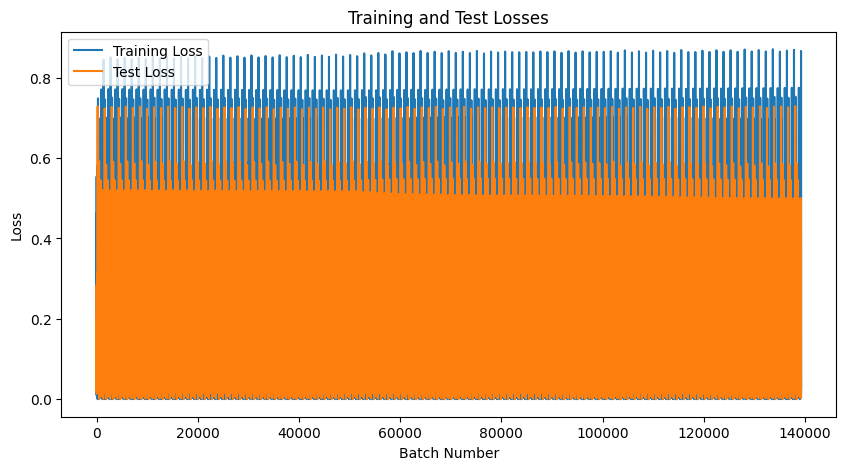

In [11]:
#TODO: plot the two arrays (be carefull they will not be the same length) Stretch the smaller oine it should fit approximatly
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss')  # Stretching the test loss plot
plt.title('Training and Test Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

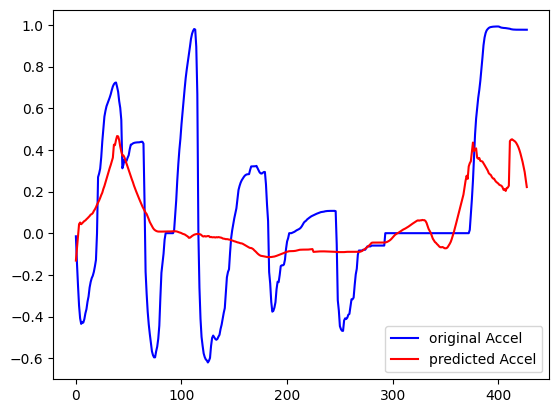

In [12]:
net.eval()
roundRobbinNumber=0

data = pd.read_feather(test_files[10])
features = data[HeaderWithoutAccel]
targets = data[outputHeader]
scaled_features = scaler.transform(features)
predData=np.empty((0, 1))


for input in scaled_features:
  out = net(torch.Tensor(input)).detach().numpy()
  predData = np.vstack((predData, out))


#plt.plot(targets[outputHeader[0]],label='original Accel',color='b')

plt.plot((targets[outputHeader[0]]),label='original Accel',color='b')
#plt.plot(targets[outputHeader[1]],label='original Steer',color='g')
plt.plot((predData[:,0]),label='predicted Accel',color='r')
#plt.plot(predData[:,1],label='predicted Steer',color='y')

#plt.ylim(-1,1)
plt.legend()
plt.show()